# Trabajo práctico N°2 - Regresión polinómica.

# Exploración de datos.

In [524]:
#librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### Se definen los conjuntos de entrenamiento, testeo y validación.

In [525]:

#se cargan los datos del csv
df = pd.read_csv('car_data.csv')

#Se eliminan del df las columnas del nombre del auto y su dueño.
df.drop('Car_Name', axis=1, inplace=True)  #Se modifica el df en sí, no genera una copia.
df.drop('Owner', axis=1, inplace=True) 

#Se definen los conjuntos de entrenamiento, testeo y validación
train = df[df['Set'] == 'Train'].copy()
test = df[df['Set'] == 'Test'].copy()
validation = df[df['Set'] == 'Validation'].copy()

#Se elimina la columna Set del df original y de los demás
df.drop('Set', axis=1, inplace=True)
train.drop('Set', axis=1, inplace=True)
test.drop('Set', axis=1, inplace=True)
validation.drop('Set', axis=1, inplace=True)


##### Se calculan las proporciones de las variables categóricas, representando las probabilidades de cada una.

In [526]:
#Se calculan las probabilidades para los tipos de combustible (Fuel_Type)
prob_fuel_type = df['Fuel_Type'].value_counts(normalize=True)

#Se calculan las probabildiades para lso tipos de vendedores (Seller_Type)
prob_seller_type = df['Seller_Type'].value_counts(normalize=True)

#Se calculan las probabilidades de los tipos de transmisiones (Transmission)
prob_transmission_type = df['Transmission'].value_counts(normalize=True)

print(prob_fuel_type,'\n')
print(prob_seller_type,'\n')
print(prob_transmission_type,'\n')

Fuel_Type
Petrol    0.794020
Diesel    0.199336
CNG       0.006645
Name: proportion, dtype: float64 

Seller_Type
Dealer        0.647841
Individual    0.352159
Name: proportion, dtype: float64 

Transmission
Manual       0.86711
Automatic    0.13289
Name: proportion, dtype: float64 



# Pre-procesamiento.

In [527]:
#librerias
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

##### Codificación.

In [528]:
#Se codifican las variables categóricas

#Variables binarias - Se definen los menos probables como True - con el fin de aprovechar el Sparse
# Transmission: Automatic está definido True (pasado a 1 por .astype(int))
transmission_train = (train['Transmission'] == 'Automatic').astype(int)

# Seller_Type: Individual está definido como True (pasado a 1 por .astype(int))
seller_train = (train['Seller_Type'] == 'Individual').astype(int)
 
#Variables de 3 categorías:
#Se crea el encoder como un array denso (no elimina los 0's)
fuel_encoder = OneHotEncoder(sparse_output=False)

#Se transforma la columna del df a una codificación one-hot, utilizando el fuel_encoder
fuel_train = fuel_encoder.fit_transform(train[['Fuel_Type']])


#Se repite el mismo procedimiento para los datos de validación y testeo
# ------ Validación
transmission_val = (validation['Transmission'] == 'Automatic').astype(int)

seller_val = (validation['Seller_Type'] == 'Individual').astype(int)

#Se aplica solo transform, ya que el modelo no debe tener información desconocida en el training
fuel_val = fuel_encoder.transform(validation[['Fuel_Type']])

# ------ Testeo
transmission_test = (test['Transmission'] == 'Automatic').astype(int)

seller_test = (test['Seller_Type'] == 'Individual').astype(int)

#Se aplica solo transform, ya que el modelo no debe tener información 'desconocida' en el training
fuel_test = fuel_encoder.transform(test[['Fuel_Type']])

#Se aprecia el orden de las categorias de combustible ya codificadas
print(fuel_encoder.categories_)

[array(['CNG', 'Diesel', 'Petrol'], dtype=object)]


##### Mapa polinómico.

In [ ]:
#Se seleccionan las columnas con valores exceptuando las categóricas y el precio de venta.
values_train = train.drop(columns = ['Selling_Price','Transmission','Seller_Type','Fuel_Type' ])
values_val = validation.drop(columns=['Selling_Price','Transmission','Seller_Type','Fuel_Type'])
values_test = test.drop(columns=['Selling_Price','Transmission','Seller_Type','Fuel_Type'])

#Se crea el mapa polinómico de grado 3, sin incluir la columna de 1's
poly = PolynomialFeatures(degree=3, include_bias=False)

values_train_poly = poly.fit_transform(values_train)

values_val_poly = poly.fit_transform(values_val)

values_test_poly = poly.fit_transform(values_test)

#PROBAR NORMALIZANDO SOLO LOS DATOS NUMÉRICOS DEL POLINOMIO


#Se concatenan todos los datos en un array de numpy antes de pasarlos a ColumnTransformer
train_combined = np.c_[
    values_train_poly,
    transmission_train.values,
    seller_train.values,
    fuel_train
]

val_combined = np.c_[
    values_val_poly,
    transmission_val.values,
    seller_val.values,
    fuel_val
]

test_combined = np.c_[
    values_test_poly,
    transmission_test.values,
    seller_test.values,
    fuel_test
]

#Se prepara el transformador de los datos, indicando la normalización

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), list(range(train_combined.shape[1])))
])

# Regresión Lineal.

In [530]:
#Se define el pipeline, indicando primero la normalización y luego el entrenamiento de la regresión lineal
pipeline = Pipeline(steps= [
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression(fit_intercept=True))
])

##### El modelo tiene 25 parámetros debido a que: 5 provienen de las variables categóricas, 3 provienen de las variables numéricas y 1 proviene del sesgo. Por otro lado, las 16 restantes provienen del mapa polinómico.

##### Entrenamiento del sistema.

In [531]:
#Se selecciona la variable a predecir para los conjuntos de datos
y_train = train['Selling_Price'].values
y_val = validation['Selling_Price'].values
y_test = test['Selling_Price'].values

#Se entrena el modelo
pipeline.fit(train_combined, y_train)


#Coeficientes
lr_model = pipeline.named_steps['regressor']
print("Coeficientes:", lr_model.coef_.shape)

display(pipeline)

Coeficientes: (24,)


,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Predicción y errores.

In [532]:
#Se realiza la predicción para los datos de entrenamiento y de validación
y_train_pred = pipeline.predict(train_combined)
y_val_pred = pipeline.predict(val_combined)

#Se calcula el MSE de entrenamiento y de validación
mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

print('Error de entrenamiento:',mse_train)
print('Error de validación:',mse_val)

Error de entrenamiento: 0.4726923559567102
Error de validación: 0.5419991552145724


# Regularización.

In [533]:
#librerias
from sklearn.linear_model import Ridge

##### Regresión Polinómica Regularizada.

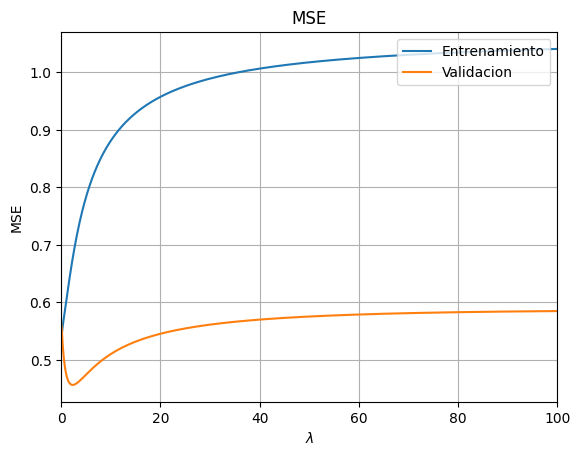

In [534]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('ridge', Ridge())
])

#Se genera el array de lambdas en el intervalo dado
lambda_min=1e-6
lambda_max=1e-2
n_samples = 1000
lambda_array = np.linspace(lambda_min, lambda_max, n_samples)

#Se generan listas vacías para cargar los valores MSE de entrenamiento y validación
mse_train_list = []
mse_val_list = []

for alpha in lambda_array:
    #Se actualiza el parámetro de ridge
    pipeline.set_params(ridge__alpha=alpha)
    
    #Se realiza el entrenamiento con el nuevo parámetro
    pipeline.fit(train_combined, y_train)
    
    #Se realizan las predicciones
    y_train_pred = pipeline.predict(train_combined)
    y_val_pred   = pipeline.predict(val_combined)
    
    #Se cargan los MSE en las listas
    mse_train_list.append(mean_squared_error(y_train, y_train_pred))
    mse_val_list.append(mean_squared_error(y_val, y_val_pred))

plt.plot(lambda_array*10000, mse_train_list,label = 'Entrenamiento')
plt.plot(lambda_array*10000, mse_val_list,label = 'Validacion')
plt.title('MSE')
plt.legend(loc = 'upper right')
plt.ylabel('MSE')
plt.xlabel(r'$\lambda$')
plt.xlim(0,100)
plt.grid()
plt.show()

##### Se calcula el MSE de testeo para el $\lambda$ minimo de validación

In [535]:
#El lambda que produce el mínimo MSE
lambda_min_val = np.min(mse_val_list)

print('Mínimo del MSE de validación:', lambda_min_val)

#Se coloca el parámetro de ridge
pipeline.set_params(ridge__alpha=lambda_min_val)
    
#Se realiza el entrenamiento con el nuevo parámetro
pipeline.fit(train_combined, y_train)
    
#Se realiza la predicción para los datos de testeo
y_test_pred = pipeline.predict(test_combined)

#Se calcula el MSE para los datos de testeo
print('MSE para el lambda que minimiza el error de validación: ',mean_squared_error(y_test, y_test_pred))

Mínimo del MSE de validación: 0.456699222074601
MSE para el lambda que minimiza el error de validación:  0.684397398746322


Preguntas:

el PolynomialFeatures, se aplica al DF completo una vez codificadas las columnas de variables categóricas?
Eso me ahorraría realizar la división de los campos numéricos. Y probablemente mejoraría el ajuste, ya que se contemplarían las mismas. Ver que además hay un problema con la cantidad de parámetros.


Dado que train y test deben seguir el mismo flujo de trabajo, podemos usar el pipeline para reducir eso

la idea es hacerlo paso a paso y luego usar el pipeline

validación: fijacion de hiperparámetros (los que no se entrenan)


los 3 pasan por el mismo flujo de trabajo
